In [97]:
!pip -qq install split-folders tqdm

In [300]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import os
import glob
import cv2
import splitfolders
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)


import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import copy
import random
import shutil
import albumentations as A
from albumentations.pytorch import ToTensorV2
import tqdm
import torch.nn.functional as F
from sklearn.metrics import (confusion_matrix, 
                             accuracy_score, 
                             average_precision_score, 
                             f1_score, 
                             roc_auc_score,
                             silhouette_score)
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.cluster import OPTICS, KMeans
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

import itertools

from torchvision.transforms import Compose, Lambda, Normalize, AutoAugment, AutoAugmentPolicy, Resize, ToTensor

# Tested on torch==1.11.0, torchvision==0.12.0
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.11.0
Torchvision Version:  0.12.0


# Data analysis

In [99]:
data_samples = glob.glob("/kaggle/input/bj-demo/images/*/*.jpg")
dataset_df = pd.DataFrame({"sample_path":data_samples})
dataset_df["label"] = dataset_df["sample_path"].apply(lambda x: x.split("/")[5])

## Problem 1: The dataset is imbalanced

In [100]:
dataset_df['label_id'] = dataset_df.groupby('label').ngroup()
dataset_df['label_id'].describe()

count    1422.000000
mean        3.047820
std         2.031897
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max         7.000000
Name: label_id, dtype: float64

In [101]:
dataset_df["label"].value_counts()

Cubism           365
Impressionism    240
Naturalism       218
Japonism         203
photo            139
Rococo           117
cartoon           75
ArtDeco           65
Name: label, dtype: int64

## Problem 2: There may be outliers

In [102]:
tmp = dataset_df[dataset_df["sample_path"] == "/kaggle/input/bj-demo/images/Cubism/charles-sheeler_still-life-1925.jpg"]

In [103]:
tmp_image = cv2.imread(tmp.iloc[0]["sample_path"])
tmp_image = cv2.cvtColor(tmp_image, cv2.COLOR_BGR2RGB)

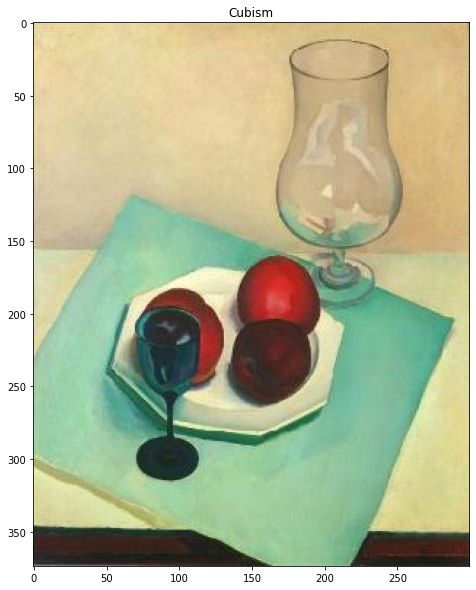

In [104]:
plt.imshow(tmp_image)
plt.title(tmp.iloc[0]["label"])
plt.show()

But it is probably precisionism: see [link](https://www.wikiart.org/en/charles-sheeler/still-life-1925)

Note that it is difficult to detect outliers without advanced knowlege in art.

## Solution #1
CNN + Boosting

Motivation: [The Image Classification Method with CNN-XGBoost Model Based on Adaptive Particle Swarm Optimization](https://www.researchgate.net/publication/350779605_The_Image_Classification_Method_with_CNN-XGBoost_Model_Based_on_Adaptive_Particle_Swarm_Optimization)

TLDR: Classic CNN models are well known as great feature extractors, however their classification layer is strongly affected by noise and class imbalance. The article presents a modified classifier based on feature extractor and XGBoost classifier.

We still need to deal with class imbalance.

### Idea #1: oversampling + augmentations

[Source](https://medium.com/analytics-vidhya/handling-imbalanced-dataset-in-image-classification-dc6f1e13aeee#:~:text=Oversampling%20means%20that%20we%20increase,it%20thus%20get%20more%20balanced.)

We need to split dataset into train/val/test subsets. As validation and test subsets do not suppose augmentations, we perform oversampling only with train. The dataset is considerably small, so undersampling will probably decrease overall quality.

In [105]:
!mkdir /kaggle/temp

mkdir: cannot create directory ‘/kaggle/temp’: File exists


In [139]:
!rm -R /kaggle/temp/*

In [140]:
# Initially we generate test subset with class balance (8 for each class)
splitfolders.fixed("../input/bj-demo/images", output="/kaggle/temp/trainval_test", oversample=False,
    seed=42, fixed=8, group_prefix=None, move=False)

!mv /kaggle/temp/trainval_test/val /kaggle/temp/test
!mv /kaggle/temp/trainval_test/train /kaggle/temp/trainval
!rm -R /kaggle/temp/trainval_test

Copying files: 1422 files [00:01, 1020.57 files/s]


In [141]:
# Then we split into tran/val subsets. Validation subset is balanced as well as test.
# The train subset is balanced with oversampling 
# i.e. making copies of images until the required number of samples is reached.
splitfolders.fixed("/kaggle/temp/trainval", output="/kaggle/temp/train_val", oversample=True,
    seed=42, fixed=16, group_prefix=None, move=False) # default values
!mv /kaggle/temp/train_val/train /kaggle/temp/train
!mv /kaggle/temp/train_val/val /kaggle/temp/val
!rm -R /kaggle/temp/train_val
!rm -R /kaggle/temp/trainval

Copying files: 1358 files [00:00, 3447.13 files/s]
Oversampling: 8 classes [00:00, 28.02 classes/s]


As dataset is small we don't train from scratch. We use pretrained on imagenet model as it is quite close to task domain. Considering the nest steps, it is reasonable to use fine-tuning strategy. (Transfer learning will keep feature extractor still).

In [142]:
data = "/kaggle/temp/"
num_classes = len(os.listdir(data + "/train"))
num_epochs = 10
img_size = 299
# When feature_extract = False, we finetune the complete model
# else we only update the reshaped layer params.
feature_extract = False 

batch_size = 16

LABEL_DICT = {"ArtDeco":0,
              "Cubism":1,
              "Impressionism":2,
              "Japonism":3,
              "Naturalism":4,
              "Rococo":5,
              "cartoon":6,
              "photo":7}

In [143]:
# representability
seed = 42
print(f'setting everything to seed {seed}')
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

setting everything to seed 42


In [144]:
data_transforms = {"train":Compose([Resize((img_size,img_size)),AutoAugment(AutoAugmentPolicy.IMAGENET), ToTensor(), Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]),
                   "val":Compose([Resize((img_size,img_size)), ToTensor(), Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])}

In [145]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'val']}
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

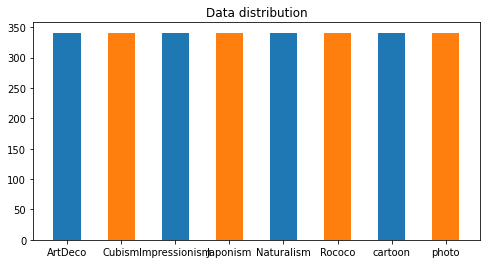

In [146]:
# Ensure our datasets have class balance
labels = image_datasets['train'].targets
_,labels_count = np.unique(labels, return_counts=True)

class_names = image_datasets['train'].classes

plt.figure(figsize=(8, 4))
plt.title('Data distribution')
plt.bar(class_names, labels_count, width=.5, color = ['C0', 'C1'])
plt.show()

In [147]:
def initialize_model(num_classes, feature_extract, use_pretrained=True):
    
    model = None
    # On small datasets complex models are more likely to overfit
    model = models.resnet18(pretrained=use_pretrained)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    
    return model

In [148]:
model = initialize_model(num_classes, feature_extract)
model = model.to(device)

In [149]:
optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=0.9)

As we have "balanced" dataset now, we can use classic accuracy and loss function

In [150]:
criterion = nn.CrossEntropyLoss()

In [151]:
def train_model(model, dataloaders, optimizer, criterion=criterion, num_epochs=num_epochs):
    
    start = time.time()
    
    metrics = {"train":{"loss":[], "acc":[]}, "val":{"loss":[], "acc":[]}}
    
    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0
            running_corrects = 0
            
            for inputs, labels in tqdm.tqdm(dataloaders[phase]):
#                 inputs = inputs["image"]
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Parameter gradients are initialized to 0
                optimizer.zero_grad()
                
                # Forward Pass
                # Getting model outputs and calculating loss
                with torch.set_grad_enabled(phase == 'train'):
                    
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    
                    # Backward pass and Optimization in training phase 
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Stats
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds==labels.data)
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            metrics[phase]["loss"].append(epoch_loss)
            metrics[phase]["acc"].append(epoch_acc.item())
                
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_weights = copy.deepcopy(model.state_dict())
                
    time_elapsed = time.time()
    
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # Best model weights are loaded here
    model.load_state_dict(best_model_weights)
    return model, metrics

In [152]:
model, history = train_model(model, dataloaders_dict, optimizer, criterion, num_epochs)

Epoch 0/9


100%|██████████| 171/171 [00:24<00:00,  6.93it/s]


train Loss: 1.4902 Acc: 0.5187


100%|██████████| 8/8 [00:01<00:00,  6.09it/s]


val Loss: 0.9280 Acc: 0.7734
Epoch 1/9


100%|██████████| 171/171 [00:25<00:00,  6.75it/s]


train Loss: 0.8233 Acc: 0.7581


100%|██████████| 8/8 [00:01<00:00,  5.38it/s]


val Loss: 0.6931 Acc: 0.8125
Epoch 2/9


100%|██████████| 171/171 [00:26<00:00,  6.52it/s]


train Loss: 0.5916 Acc: 0.8120


100%|██████████| 8/8 [00:01<00:00,  6.65it/s]


val Loss: 0.6152 Acc: 0.8047
Epoch 3/9


100%|██████████| 171/171 [00:25<00:00,  6.82it/s]


train Loss: 0.4502 Acc: 0.8699


100%|██████████| 8/8 [00:01<00:00,  7.67it/s]


val Loss: 0.6156 Acc: 0.8281
Epoch 4/9


100%|██████████| 171/171 [00:24<00:00,  6.98it/s]


train Loss: 0.3585 Acc: 0.8955


100%|██████████| 8/8 [00:01<00:00,  7.57it/s]


val Loss: 0.6143 Acc: 0.7969
Epoch 5/9


100%|██████████| 171/171 [00:24<00:00,  7.03it/s]


train Loss: 0.3093 Acc: 0.9073


100%|██████████| 8/8 [00:01<00:00,  6.20it/s]


val Loss: 0.5750 Acc: 0.8359
Epoch 6/9


100%|██████████| 171/171 [00:24<00:00,  6.91it/s]


train Loss: 0.2464 Acc: 0.9318


100%|██████████| 8/8 [00:01<00:00,  7.85it/s]


val Loss: 0.6136 Acc: 0.8203
Epoch 7/9


100%|██████████| 171/171 [00:24<00:00,  7.09it/s]


train Loss: 0.2281 Acc: 0.9373


100%|██████████| 8/8 [00:01<00:00,  7.66it/s]


val Loss: 0.6359 Acc: 0.7969
Epoch 8/9


100%|██████████| 171/171 [00:25<00:00,  6.79it/s]


train Loss: 0.1932 Acc: 0.9428


100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


val Loss: 0.6673 Acc: 0.7891
Epoch 9/9


100%|██████████| 171/171 [00:24<00:00,  6.97it/s]


train Loss: 0.1754 Acc: 0.9512


100%|██████████| 8/8 [00:01<00:00,  7.84it/s]

val Loss: 0.6262 Acc: 0.8047
Training complete in 27767315m 59s
Best val Acc: 0.835938


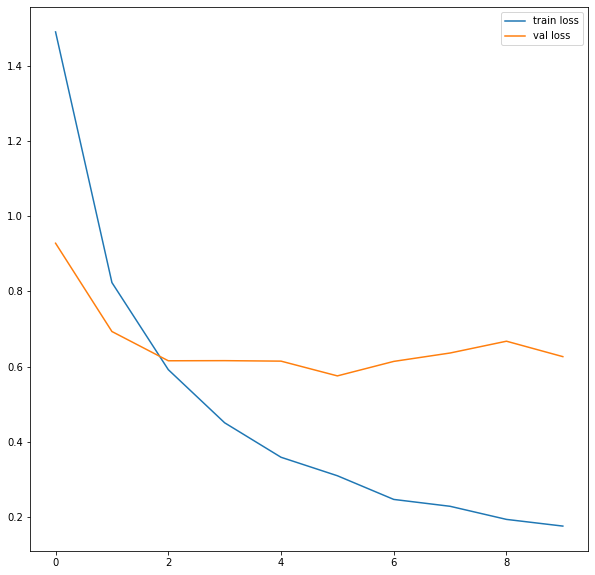

In [162]:
plt.plot(history["train"]["loss"], label="train loss")
plt.plot(history["val"]["loss"], label = "val loss")
plt.legend()
plt.show()

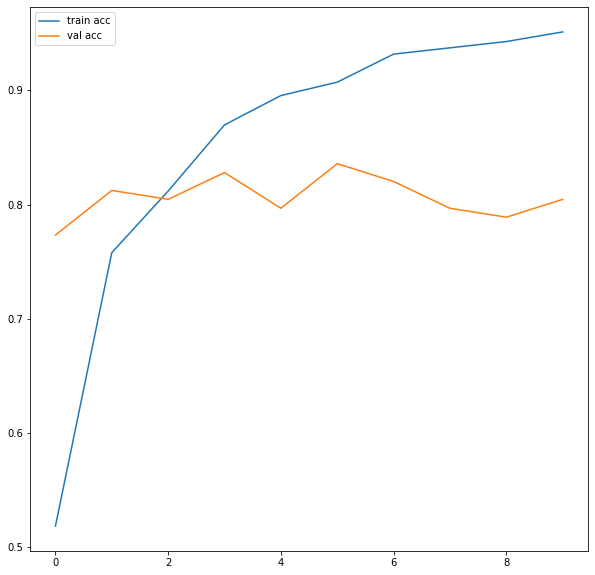

In [163]:
plt.plot(history["train"]["acc"], label="train acc")
plt.plot(history["val"]["acc"], label = "val acc")
plt.legend()
plt.show()

The plost demonstrate overfitting (probably to oversampled classes)

In [164]:
def predict(in_path):
    prediction = None
    in_image = cv2.imread(in_path)
    
    with torch.no_grad():
        in_image = torch.tensor(cv2.cvtColor(in_image, cv2.COLOR_BGR2RGB)).to(device)
        in_image = in_image.permute(2,0,1)
        in_image = torch.unsqueeze(in_image, 0)
        in_image = in_image.float() / 255.

        prediction = model(in_image)
        prob = F.softmax(prediction, dim=1).detach().cpu().numpy()
        _, pred = torch.max(prediction, dim=1)
    return (pred.item(), prob.tolist()) # [0][pred.item()].item()

In [165]:
model.eval()
model = model.to()
test_files = glob.glob("/kaggle/temp/test/*/*.jpg")

In [166]:
y_true = []
y_pred = []
y_prob = []
for test_file in tqdm.tqdm(test_files):
    label = test_file.split("/")[-2]
    pred = predict(test_file)
    y_true.append(LABEL_DICT[label])
    y_pred.append(pred[0])
    y_prob.append(pred[1][0])

100%|██████████| 64/64 [00:00<00:00, 95.09it/s]


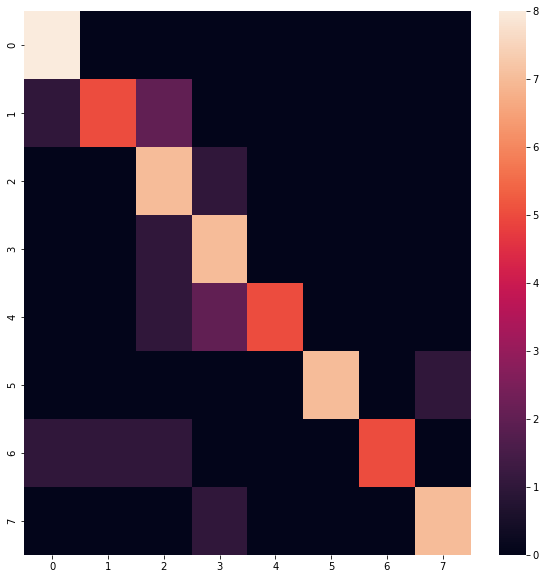

In [167]:
conf_matrix = confusion_matrix(y_true, y_pred, labels = [0,1,2,3,4,5,6,7])
uniform_data = np.random.rand(10, 12)
ax = sns.heatmap(conf_matrix)

In [168]:
accuracy_score(y_pred, y_true)

0.796875

In [169]:
f1_score(y_pred, y_true, average = "weighted")

0.7953985524709208

In [170]:
torch.save(model.state_dict(), "/kaggle/working/classifier_oversampling.pt")

### Idea #2: loss with weights

In [171]:
!rm -R /kaggle/temp/*

In [172]:
# Create balanced test and val subsets and imbalanced train subset
splitfolders.fixed("../input/bj-demo/images", output="/kaggle/temp/trainval_test", oversample=False,
    seed=42, fixed=8, group_prefix=None, move=False)

!mv /kaggle/temp/trainval_test/val /kaggle/temp/test
!mv /kaggle/temp/trainval_test/train /kaggle/temp/trainval
!rm -R /kaggle/temp/trainval_test

splitfolders.fixed("/kaggle/temp/trainval", output="/kaggle/temp/train_val", oversample=False,
    seed=42, fixed=16, group_prefix=None, move=False) # default values
!mv /kaggle/temp/train_val/train /kaggle/temp/train
!mv /kaggle/temp/train_val/val /kaggle/temp/val
!rm -R /kaggle/temp/train_val
!rm -R /kaggle/temp/trainval

Copying files: 1422 files [00:01, 900.69 files/s] 
Copying files: 1358 files [00:00, 5269.52 files/s]


In [173]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'val']}


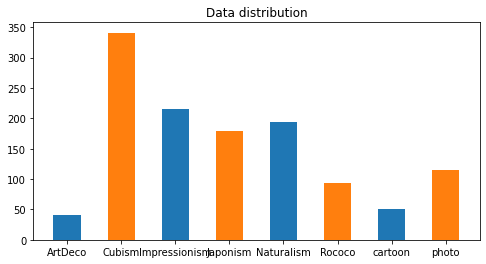

In [174]:
labels = image_datasets['train'].targets
_,labels_count = np.unique(labels, return_counts=True)

class_names = image_datasets['train'].classes

plt.figure(figsize=(8, 4))
plt.title('Data distribution')
plt.bar(class_names, labels_count, width=.5, color = ['C0', 'C1'])
plt.show()

In [175]:
labels_count

array([ 41, 341, 216, 179, 194,  93,  51, 115])

In [176]:
# Generate label weights
label_weights = torch.Tensor([1 - (x/len(image_datasets['train'])) for x in labels_count]).to(device)
label_weights

tensor([0.9667, 0.7228, 0.8244, 0.8545, 0.8423, 0.9244, 0.9585, 0.9065],
       device='cuda:0')

[source](https://naadispeaks.wordpress.com/2021/07/31/handling-imbalanced-classes-with-weighted-loss-in-pytorch/)

In [177]:
model = initialize_model(num_classes, feature_extract)
model = model.to(device)

In [178]:
criterion = nn.CrossEntropyLoss(label_weights)
optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=0.9)

In [179]:
model, history = train_model(model, dataloaders_dict, optimizer, criterion, num_epochs)

Epoch 0/9


100%|██████████| 77/77 [00:11<00:00,  6.75it/s]


train Loss: 1.6797 Acc: 0.4350


100%|██████████| 8/8 [00:01<00:00,  7.59it/s]


val Loss: 1.6416 Acc: 0.5078
Epoch 1/9


100%|██████████| 77/77 [00:11<00:00,  6.86it/s]


train Loss: 1.1905 Acc: 0.6341


100%|██████████| 8/8 [00:01<00:00,  4.77it/s]


val Loss: 1.2215 Acc: 0.6172
Epoch 2/9


100%|██████████| 77/77 [00:11<00:00,  6.87it/s]


train Loss: 0.9639 Acc: 0.7057


100%|██████████| 8/8 [00:01<00:00,  7.47it/s]


val Loss: 1.0196 Acc: 0.6641
Epoch 3/9


100%|██████████| 77/77 [00:11<00:00,  6.89it/s]


train Loss: 0.8236 Acc: 0.7366


100%|██████████| 8/8 [00:01<00:00,  7.66it/s]


val Loss: 0.8216 Acc: 0.7578
Epoch 4/9


100%|██████████| 77/77 [00:11<00:00,  6.49it/s]


train Loss: 0.7071 Acc: 0.7902


100%|██████████| 8/8 [00:01<00:00,  7.72it/s]


val Loss: 0.7800 Acc: 0.7578
Epoch 5/9


100%|██████████| 77/77 [00:11<00:00,  6.93it/s]


train Loss: 0.6399 Acc: 0.8033


100%|██████████| 8/8 [00:01<00:00,  7.74it/s]


val Loss: 0.6776 Acc: 0.7812
Epoch 6/9


100%|██████████| 77/77 [00:11<00:00,  6.91it/s]


train Loss: 0.5951 Acc: 0.8130


100%|██████████| 8/8 [00:01<00:00,  7.57it/s]


val Loss: 0.6755 Acc: 0.7422
Epoch 7/9


100%|██████████| 77/77 [00:11<00:00,  6.50it/s]


train Loss: 0.5104 Acc: 0.8325


100%|██████████| 8/8 [00:01<00:00,  7.83it/s]


val Loss: 0.6362 Acc: 0.7734
Epoch 8/9


100%|██████████| 77/77 [00:10<00:00,  7.00it/s]


train Loss: 0.4682 Acc: 0.8585


100%|██████████| 8/8 [00:01<00:00,  7.76it/s]


val Loss: 0.5814 Acc: 0.7969
Epoch 9/9


100%|██████████| 77/77 [00:11<00:00,  6.49it/s]


train Loss: 0.4346 Acc: 0.8675


100%|██████████| 8/8 [00:01<00:00,  7.77it/s]

val Loss: 0.6035 Acc: 0.7969
Training complete in 27767318m 55s
Best val Acc: 0.796875


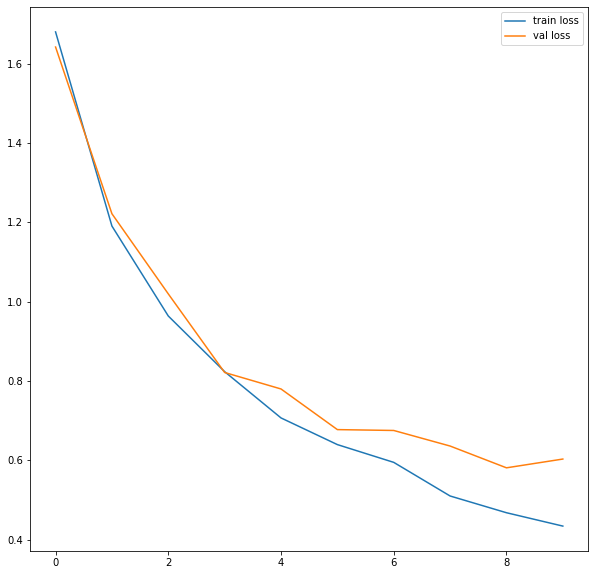

In [180]:
plt.plot(history["train"]["loss"], label="train loss")
plt.plot(history["val"]["loss"], label = "val loss")
plt.legend()
plt.show()

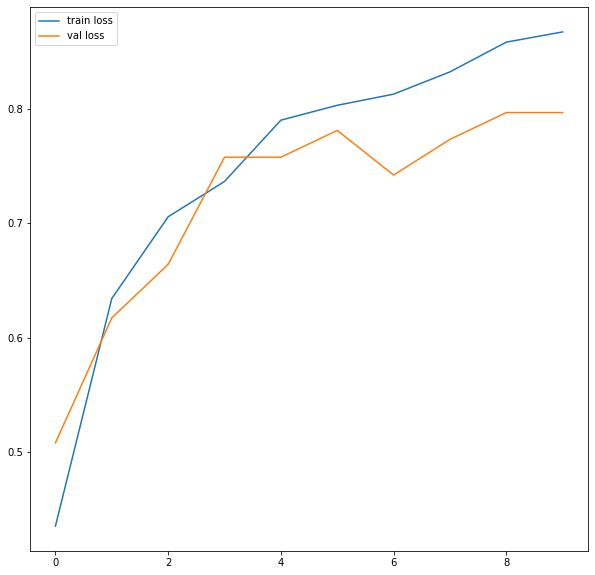

In [181]:
plt.plot(history["train"]["acc"], label="train loss")
plt.plot(history["val"]["acc"], label = "val loss")
plt.legend()
plt.show()

In [182]:
model.eval()
model = model.to()
test_files = glob.glob("/kaggle/temp/test/*/*.jpg")

In [183]:
y_true = []
y_pred = []
y_prob = []
for test_file in tqdm.tqdm(test_files):
    label = test_file.split("/")[-2]
    pred = predict(test_file)
    y_true.append(LABEL_DICT[label])
    y_pred.append(pred[0])
    y_prob.append(pred[1][0])

100%|██████████| 64/64 [00:00<00:00, 95.76it/s]


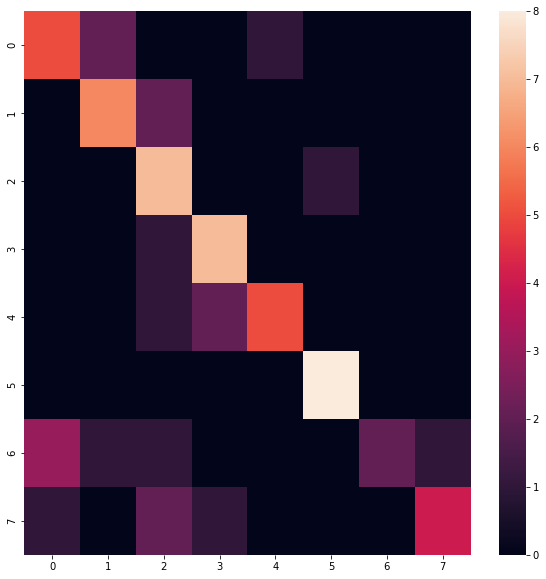

In [184]:
conf_matrix = confusion_matrix(y_true, y_pred, labels = [0,1,2,3,4,5,6,7])
uniform_data = np.random.rand(10, 12)
ax = sns.heatmap(conf_matrix)

In [185]:
accuracy_score(y_pred, y_true)

0.6875

In [186]:
f1_score(y_pred, y_true, average = "weighted")

0.7026117673176497

In [187]:
torch.save(model.state_dict(), "/kaggle/working/classifier_weights.pt")

As we see, the oversampling strategy works better. This may be due to strong augmentations. 

However in some situations weights may be better. It depends on context

# Task 2

Here we generate embeddings and try to asess how good the classes are separated.

Another option is to try to cluster the embeddings and distinguish the outliers (see data analysis).

In [188]:
embedding_paths = glob.glob("/kaggle/input/bj-demo/images/*/*.jpg")

In [205]:
def initialize_feat_extractor(num_classes, imagenet_pretrained = False):
    
    model = None
    model = models.resnet18(pretrained=True)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    if not imagenet_pretrained:
        state_dict = torch.load("/kaggle/working/classifier_oversampling.pt", map_location=torch.device('cpu'))
        model.load_state_dict(state_dict)
    extractor = torch.nn.Sequential(*(list(model.children())[:-1]))
    extractor.eval()
    extractor = extractor.to(device)
    return extractor

def get_feature(model, in_path):
    in_image = cv2.imread(in_path)
    prediction = None
    with torch.no_grad():
        in_image = torch.tensor(cv2.cvtColor(in_image, cv2.COLOR_BGR2RGB)).to(device)
        in_image = in_image.permute(2,0,1)
        in_image = torch.unsqueeze(in_image, 0)
        in_image = in_image.float() / 255.

        prediction = model(in_image)
    return torch.flatten(prediction).cpu().numpy()

May be we did not need training above? 

The model, pretrained on imagenet, may give good results.

In [206]:
num_classes = len(os.listdir("/kaggle/input/bj-demo/images"))

pretrained_extractor = initialize_feat_extractor(num_classes)

imagenet_extractor = initialize_feat_extractor(num_classes, imagenet_pretrained = True)


In [207]:
pretrained_embeddings = []
for emb_path in tqdm.tqdm(embedding_paths):
    pretrained_embeddings.append(get_feature(pretrained_extractor, emb_path))

100%|██████████| 1422/1422 [00:16<00:00, 88.44it/s]


In [208]:
imagenet_embeddings = []
for emb_path in tqdm.tqdm(embedding_paths):
    imagenet_embeddings.append(get_feature(imagenet_extractor, emb_path))

100%|██████████| 1422/1422 [00:16<00:00, 87.88it/s]


In [209]:
embeddings_df = pd.DataFrame({"paths":embedding_paths, 
                              "pretrained_embeddings":pretrained_embeddings, 
                              "imagenet_embeddings": imagenet_embeddings})

In [210]:
# Get nice projection of embeddings into 2d-space
pretrained_embeddings_2d = TSNE(n_components=2, learning_rate='auto',init='random').fit_transform(np.array(pretrained_embeddings))
imagenet_embeddings_2d = TSNE(n_components=2, learning_rate='auto',init='random').fit_transform(np.array(imagenet_embeddings))

In [211]:
embeddings_df["pretrained_embeddings_2d"] = pretrained_embeddings_2d.tolist()
embeddings_df["imagenet_embeddings_2d"] = imagenet_embeddings_2d.tolist()
embeddings_df["gt_label"] = embeddings_df["paths"].apply(lambda x: x.split("/")[5])

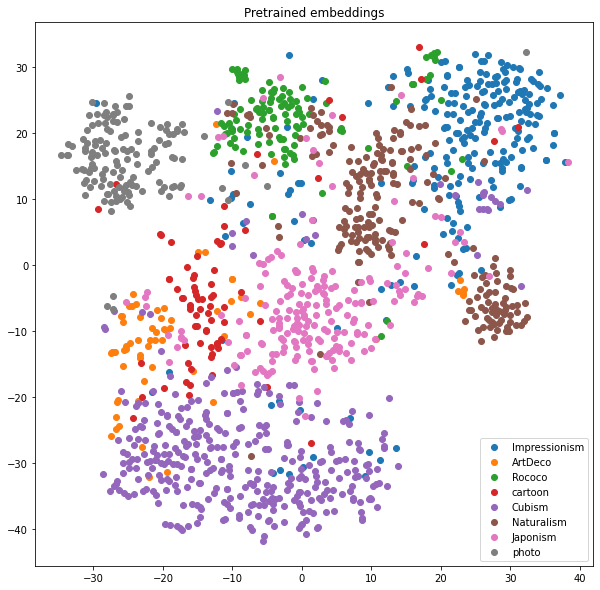

In [212]:
u_labels = embeddings_df["gt_label"].unique()
for i in u_labels:
    plt.scatter(np.array(embeddings_df[embeddings_df["gt_label"]==i]["pretrained_embeddings_2d"].tolist())[:,0] , 
                np.array(embeddings_df[embeddings_df["gt_label"]==i]["pretrained_embeddings_2d"].tolist())[:,1] , 
                label = i)
plt.title("Pretrained embeddings")
plt.legend()
plt.show()

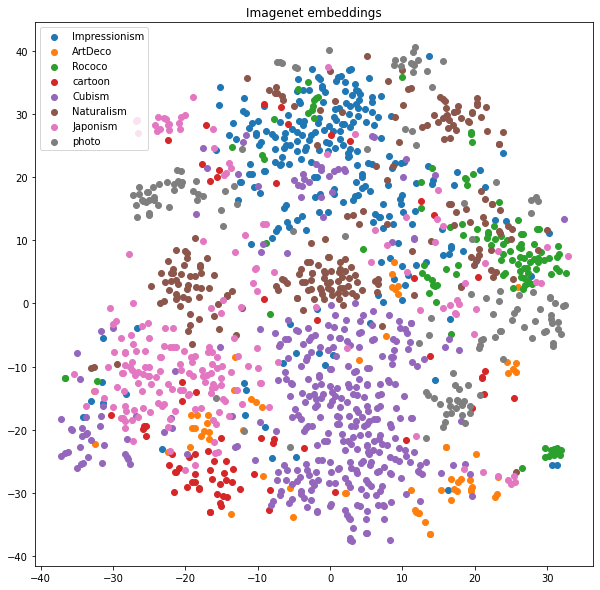

In [213]:
u_labels = embeddings_df["gt_label"].unique()
for i in u_labels:
    plt.scatter(np.array(embeddings_df[embeddings_df["gt_label"]==i]["imagenet_embeddings_2d"].tolist())[:,0] , 
                np.array(embeddings_df[embeddings_df["gt_label"]==i]["imagenet_embeddings_2d"].tolist())[:,1] , 
                label = i)
plt.title("Imagenet embeddings")
plt.legend()
plt.show()

Pretrained embedding are obviously better. 

However, if there was no gpu or labeling, the clusterization problem still could have been solved

(at least for some labels)

To asess the cluster quality we will use the [silhouette score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html).

The score is calculated between two sets. Here we will find the score between every pair of classes.

! one-vs-all may be bad if the cluster is surrounded by others.

In [214]:
# here add silhouette
embeddings_df["gt_labelnum"] = embeddings_df["gt_label"].apply(lambda x: LABEL_DICT[x])


In [215]:
def calc_silhouette(classA:int, classB: int, df:pd.DataFrame, key: str) -> float:
    classA_df = embeddings_df[embeddings_df["gt_labelnum"] == classA]
    classB_df = embeddings_df[embeddings_df["gt_labelnum"] == classB]
    combined_df = pd.concat([classA_df,classB_df])
    return silhouette_score(combined_df[key].tolist(), combined_df["gt_labelnum"].tolist())

In [216]:
combinations_list = list(itertools.combinations(list(embeddings_df["gt_labelnum"].unique()), 2))
classes_A = []
classes_B = []
silhouette_list = []
for item in combinations_list:
    classes_A.append(item[0])
    classes_B.append(item[1])
    silhouette_list.append(calc_silhouette(item[0], item[1], embeddings_df, key = "pretrained_embeddings"))
pretrained_silhouette_df = pd.DataFrame({"Class A": classes_A, "Class B": classes_B, "silhouette score": silhouette_list})

In [217]:
pretrained_silhouette_df

,Class A,Class B,silhouette score
0,2,0,0.216202
1,2,5,0.107561
2,2,6,0.194372
3,2,1,0.167461
4,2,4,0.083585
5,2,3,0.140813
6,2,7,0.189929
7,0,5,0.207150
8,0,6,0.078417
9,0,1,0.098550


In [218]:
classes_A = []
classes_B = []
silhouette_list = []
for item in combinations_list:
    classes_A.append(item[0])
    classes_B.append(item[1])
    silhouette_list.append(calc_silhouette(item[0], item[1], embeddings_df, key = "imagenet_embeddings"))
imagenet_silhouette_df = pd.DataFrame({"Class A": classes_A, "Class B": classes_B, "silhouette score": silhouette_list})

In [219]:
imagenet_silhouette_df

,Class A,Class B,silhouette score
0,2,0,0.154224
1,2,5,0.075758
2,2,6,0.160655
3,2,1,0.089683
4,2,4,0.053339
5,2,3,0.094271
6,2,7,0.102140
7,0,5,0.114365
8,0,6,0.026373
9,0,1,0.054238


It would be nice to remove dataset noise. One solution is to use OPTICS algorithm.

I have tried to cluster embeddings with OPTICS, but surprisingly did not achieve good result. The problem may be in [curse of dimensionality](https://towardsdatascience.com/curse-of-dimensionality-a-curse-to-machine-learning-c122ee33bfeb).

Lets check the clusterization result

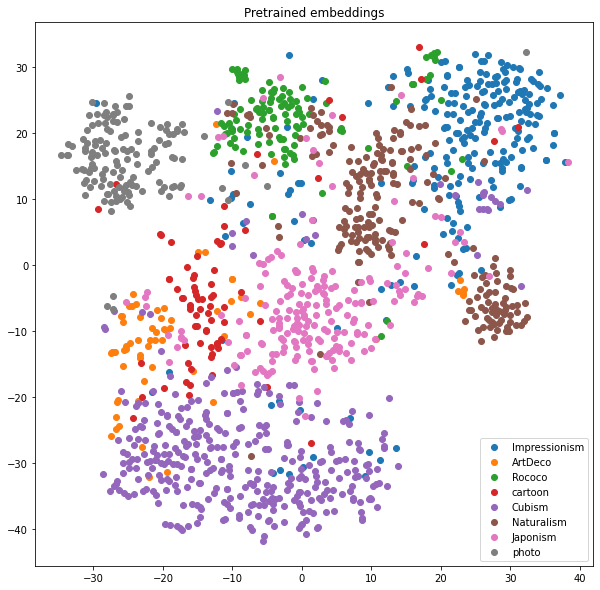

In [221]:
u_labels = embeddings_df["gt_label"].unique()
for i in u_labels:
    plt.scatter(np.array(embeddings_df[embeddings_df["gt_label"]==i]["pretrained_embeddings_2d"].tolist())[:,0] , 
                np.array(embeddings_df[embeddings_df["gt_label"]==i]["pretrained_embeddings_2d"].tolist())[:,1] , 
                label = i)
plt.title("Pretrained embeddings")
plt.legend()
plt.show()

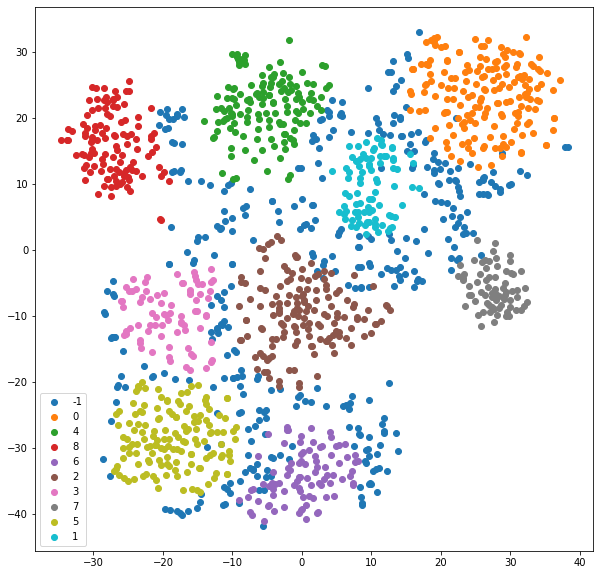

In [255]:
clusters = OPTICS(min_samples = 70, xi=0.01)
clusters.fit(pretrained_embeddings_2d)

embeddings_df["cluster_label"] = clusters.labels_

u_labels = embeddings_df["cluster_label"].unique()
rgb_values = sns.color_palette("husl", 14)
for i in u_labels:
#     if i == -1: continue
    plt.scatter(np.array(embeddings_df[embeddings_df["cluster_label"]==i]["pretrained_embeddings_2d"].tolist())[:,0] , 
                np.array(embeddings_df[embeddings_df["cluster_label"]==i]["pretrained_embeddings_2d"].tolist())[:,1] , label = i) #, color=rgb_values[i])
plt.legend()
plt.show()

Note that clusters are similar to classes from labeling.

However, ArtDeco and Cartoon became the same class. Still, there is possibility to separate them (note the boarder)

There could be possibly even better result using more advanced techniques.

This result can be used to remove outliers (sacrificing the dataset size).

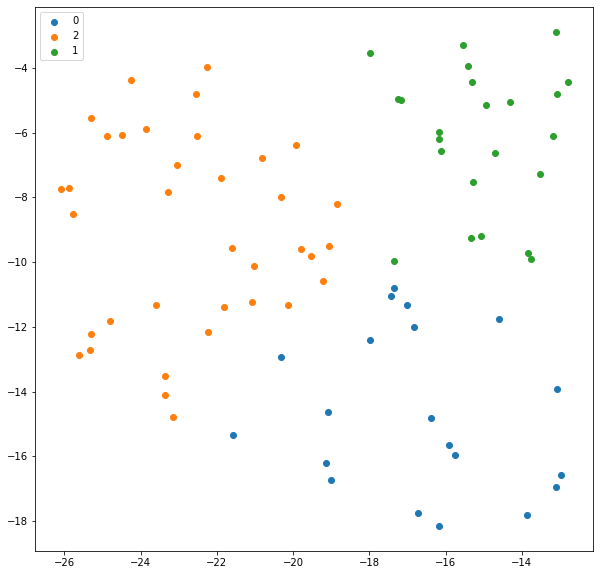

In [302]:
embeddings_df_3 = embeddings_df[embeddings_df["cluster_label"]==3].copy()
# clusters = OPTICS(min_samples = 18, xi=1.e-3)
clusters = KMeans(n_clusters = 3, random_state=42)
clusters.fit(embeddings_df_3["pretrained_embeddings_2d"].to_list())
embeddings_df_3["cluster_label_st2"] = clusters.labels_

u_labels = embeddings_df_3["cluster_label_st2"].unique()
rgb_values = sns.color_palette("husl", 14)
for i in u_labels:
#     if i == -1: continue
    plt.scatter(np.array(embeddings_df_3[embeddings_df_3["cluster_label_st2"]==i]["pretrained_embeddings_2d"].tolist())[:,0] , 
                np.array(embeddings_df_3[embeddings_df_3["cluster_label_st2"]==i]["pretrained_embeddings_2d"].tolist())[:,1] , label = i) #, color=rgb_values[i])
plt.legend()
plt.show()

Lost class recovered

In [352]:
embeddings_df_res = pd.concat([embeddings_df, embeddings_df_3["cluster_label_st2"]], axis = 1, join = "outer")
embeddings_df_res.loc[embeddings_df_res["cluster_label"]==6, "cluster_label"] = 5
embeddings_df_res.loc[embeddings_df_res["cluster_label_st2"]==1, "cluster_label"] = 6
embeddings_df_res

,paths,pretrained_embeddings,imagenet_embeddings,pretrained_embeddings_2d,imagenet_embeddings_2d,gt_label,gt_labelnum,cluster_label,cluster_label_st2
0,/kaggle/input/bj-demo/images/Impressionism/pau...,"[0.2977924, 0.5097534, 1.0638214, 1.108568, 0....","[0.4522834, 0.56896514, 0.79019374, 0.38966966...","[28.719833374023438, 14.78178596496582]","[6.765962600708008, 13.715887069702148]",Impressionism,2,-1,NaN
1,/kaggle/input/bj-demo/images/Impressionism/pie...,"[0.45813334, 0.27153686, 0.069398075, 1.185244...","[1.0454112, 0.23239356, 0.15760773, 0.59222317...","[25.629886627197266, 29.2801456451416]","[2.0372090339660645, 33.6119270324707]",Impressionism,2,0,NaN
2,/kaggle/input/bj-demo/images/Impressionism/joa...,"[0.39953813, 0.21478486, 1.050751, 0.4029701, ...","[0.54769623, 0.49007434, 0.8008321, 0.26858845...","[24.155017852783203, 13.08371353149414]","[-4.027233600616455, 22.86504554748535]",Impressionism,2,-1,NaN
3,/kaggle/input/bj-demo/images/Impressionism/pau...,"[0.28563625, 0.22489244, 0.41205797, 0.5561690...","[0.580393, 0.28342146, 0.12729098, 0.58343625,...","[21.46111297607422, -2.952871322631836]","[10.384766578674316, 2.990203857421875]",Impressionism,2,-1,NaN
4,/kaggle/input/bj-demo/images/Impressionism/dav...,"[0.019111684, 0.31537342, 0.4833817, 0.6695326...","[0.086464666, 0.6419951, 0.26506567, 0.1341252...","[33.754119873046875, 22.80683708190918]","[2.762537717819214, 24.39103126525879]",Impressionism,2,0,NaN
...,...,...,...,...,...,...,...,...,...
1417,/kaggle/input/bj-demo/images/photo/004430.jpg,"[0.699724, 0.3162339, 0.8248184, 1.2662191, 1....","[0.47241056, 0.9193881, 0.7051153, 0.96716833,...","[-26.779016494750977, 15.861942291259766]","[-12.121769905090332, 24.470518112182617]",photo,7,8,NaN
1418,/kaggle/input/bj-demo/images/photo/005873.jpg,"[0.8324461, 1.6524138, 0.4383622, 0.36241364, ...","[0.33142737, 0.9900289, 0.31255385, 0.5139535,...","[-23.528060913085938, 18.792236328125]","[27.82091522216797, 14.372776985168457]",photo,7,8,NaN
1419,/kaggle/input/bj-demo/images/photo/001847.jpg,"[1.2205918, 1.5042881, 0.60274136, 0.6453149, ...","[0.551329, 0.85138214, 0.8390391, 0.6017941, 0...","[-33.68669891357422, 18.423316955566406]","[-4.839666366577148, 37.363487243652344]",photo,7,8,NaN
1420,/kaggle/input/bj-demo/images/photo/007104.jpg,"[1.2019722, 1.2645326, 0.5847196, 1.3119702, 0...","[0.98948133, 0.72828597, 0.32434756, 2.4290836...","[-17.252792358398438, 16.14080047607422]","[13.7243070602417, -5.0527801513671875]",photo,7,-1,NaN


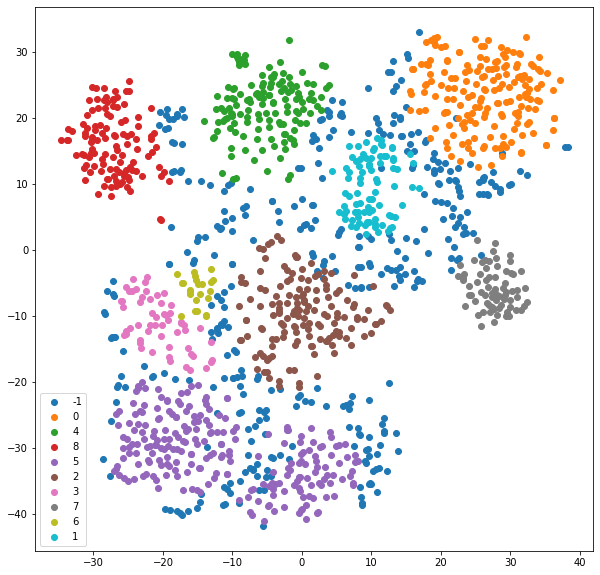

In [353]:
u_labels = embeddings_df_res["cluster_label"].unique()
for i in u_labels:
#     if i == -1: continue
    plt.scatter(np.array(embeddings_df_res[embeddings_df_res["cluster_label"]==i]["pretrained_embeddings_2d"].tolist())[:,0] , 
                np.array(embeddings_df_res[embeddings_df_res["cluster_label"]==i]["pretrained_embeddings_2d"].tolist())[:,1] , label = i) #, color=rgb_values[i])
plt.legend()
plt.show()

The 1 and 7 clusters are too separate, so it is better too keep them as a separate cluster and treat as a single class after inference

In [354]:
embeddings_df.to_excel("/kaggle/working/embeddings_df.xlsx")

# Task 3

Here we try to perform classification with gradient boosting.

In [ ]:
!ls /kaggle/temp

In [ ]:
X = embeddings_df["pretrained_embeddings"].tolist()
y = embeddings_df["gt_labelnum"].tolist()

In [372]:
def balanced_subsample(x,y,subsample_size=1.0):

    class_xs = []
    min_elems = None

    for yi in np.unique(y):
        elems = x[(y == yi)]
        class_xs.append((yi, elems))
        if min_elems == None or elems.shape[0] < min_elems:
            min_elems = elems.shape[0]

    use_elems = min_elems
    if subsample_size < 1:
        use_elems = int(min_elems*subsample_size)

    xs = []
    ys = []

    for ci,this_xs in class_xs:
        if len(this_xs) > use_elems:
            np.random.shuffle(this_xs)

        x_ = this_xs[:use_elems]
        y_ = np.empty(use_elems)
        y_.fill(ci)

        xs.append(x_)
        ys.append(y_)

    xs = np.concatenate(xs)
    ys = np.concatenate(ys)

    return xs,ys

In [362]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.045, random_state=42, stratify = y)

In [371]:
from collections import Counter
Counter(y_test)

Counter({7: 6, 1: 17, 6: 3, 4: 10, 3: 9, 2: 11, 5: 5, 0: 3})

In [363]:
clf = GradientBoostingClassifier(n_estimators=8, random_state=42).fit(X_train, y_train)

In [364]:
clf.score(X_test, y_test)
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

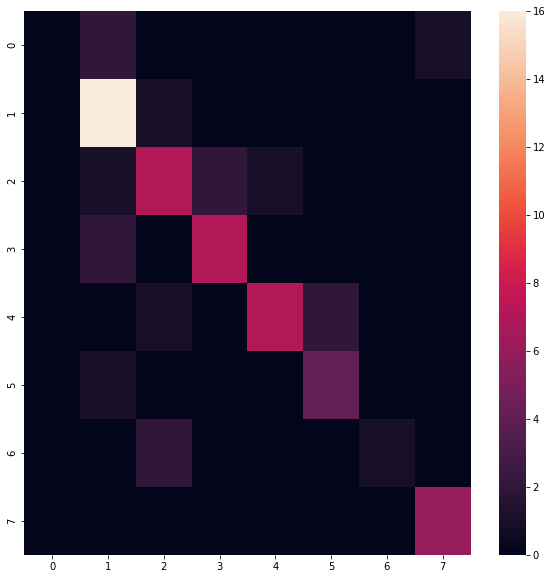

In [365]:
conf_matrix = confusion_matrix(y_test, y_pred, labels = [0,1,2,3,4,5,6,7])
uniform_data = np.random.rand(10, 12)
ax = sns.heatmap(conf_matrix)

In [366]:
accuracy_score(y_pred, y_test)

0.75

In [367]:
f1_score(y_pred, y_test, average = "weighted")

0.7749793609168609

# Conclusion

The theory, presented in base article has been proved to work. However, there may be situations, when simple classifier works better.

Still, there is much space to improve the results.

There are following ideas:

1) Try metric learning - Done

2) Generate synthetic data - deal with class imbalance and enlarge dataset size. Sources: [#1](https://towardsdatascience.com/how-to-make-artistic-images-with-neural-style-transfer-345a376d56cf) [#2](https://paperswithcode.com/task/style-transfer)

3) Use clusterization to remove labeling outliers

4) In task #1 use metrics with class weights (instead of oversampling) - Done

5) Try more advanced clustering algorithms - Done

6) Try more advanced gradient boosting algoruthms

7) Hyperparameter tuning (see main article)

8) Try auto-sklearn (basically this is a combination of 6 and 7)